# K2 C18 M67 lightcurve search

In [1]:
import lightkurve

In [2]:
lightkurve.__version__

'1.0b26.dev'

In [3]:
# %load /Users/obsidian/Desktop/defaults.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from tqdm import tqdm_notebook as tqdm

The M67 data is stored as 50 x 50 pixel blocks.  There's apparently no way to figure out which source is in which block!  Whyyyy?   
Let's just manually reverse engineer the pointing.


We'll first identify the list of Custom Aperture IDs that targeted M67.  These Custom Aperture IDs resemble per-target EPIC ids, except that their first three numbers are less than 201.  We can retrieve this list from the K2 website.

We'll then identify a way to derive the cone of sky that each 50 x 50 block observed.

In [4]:
df_targs = pd.read_csv('https://keplerscience.arc.nasa.gov/data/campaigns/c18/K2Campaign18targets.csv')

In [5]:
df_targs.columns

Index(['EPIC', 'RA', 'Dec', 'Kp', 'InvestigationIDs'], dtype='object')

In [6]:
M67_ids = df_targs['InvestigationIDs'].str.contains('M67')

In [7]:
M67_ids.sum()

441

In [8]:
df_M67 = df_targs[M67_ids].reset_index(drop=True)

In [9]:
df_M67.tail()

,EPIC,RA,Dec,Kp,InvestigationIDs
436,200233638,NaN,NaN,NaN,GO18002|GO18003|GO18004|GO18005|GO18011|GO1801...
437,200233639,NaN,NaN,NaN,GO18002|GO18003|GO18004|GO18005|GO18011|GO1801...
438,200233640,NaN,NaN,NaN,GO18002|GO18003|GO18004|GO18005|GO18011|GO1801...
439,200233641,NaN,NaN,NaN,GO18002|GO18003|GO18004|GO18005|GO18011|GO1801...
440,200233642,NaN,NaN,NaN,GO18002|GO18003|GO18004|GO18005|GO18011|GO1801...


In [10]:
df_M67['fn'] = df_M67['EPIC'].apply(lambda x:"ktwo{}-c18_lc/ktwo{}-c18_lpd-targ.fits.gz".format(x,x))
df_M67['fn_file'] = df_M67['EPIC'].apply(lambda x:"ktwo{}-c18_lpd-targ.fits.gz".format(x))

In [11]:
df_M67.head()

,EPIC,RA,Dec,Kp,InvestigationIDs,fn,fn_file
0,200233202,NaN,NaN,NaN,GO18002|GO18003|GO18004|GO18005|GO18011|GO1801...,ktwo200233202-c18_lc/ktwo200233202-c18_lpd-tar...,ktwo200233202-c18_lpd-targ.fits.gz
1,200233203,NaN,NaN,NaN,GO18002|GO18003|GO18004|GO18005|GO18011|GO1801...,ktwo200233203-c18_lc/ktwo200233203-c18_lpd-tar...,ktwo200233203-c18_lpd-targ.fits.gz
2,200233204,NaN,NaN,NaN,GO18002|GO18003|GO18004|GO18005|GO18011|GO1801...,ktwo200233204-c18_lc/ktwo200233204-c18_lpd-tar...,ktwo200233204-c18_lpd-targ.fits.gz
3,200233205,NaN,NaN,NaN,GO18002|GO18003|GO18004|GO18005|GO18011|GO1801...,ktwo200233205-c18_lc/ktwo200233205-c18_lpd-tar...,ktwo200233205-c18_lpd-targ.fits.gz
4,200233206,NaN,NaN,NaN,GO18002|GO18003|GO18004|GO18005|GO18011|GO1801...,ktwo200233206-c18_lc/ktwo200233206-c18_lpd-tar...,ktwo200233206-c18_lpd-targ.fits.gz


In [12]:
import os, sys

In [13]:
df_M67['EPIC'].values[-5:]

array([200233638, 200233639, 200233640, 200233641, 200233642])

In [14]:
! ls /Users/obsidian/.lightkurve-cache/mastDownload/K2/ | head -n 10

ktwo200008644-c05_lc
ktwo200008645-c05_lc
ktwo200008646-c05_lc
ktwo200008647-c05_lc
ktwo200008648-c05_lc
ktwo200008649-c05_lc
ktwo200008650-c05_lc
ktwo200008651-c05_lc
ktwo200008652-c05_lc
ktwo200008653-c05_lc


In [15]:
from astropy import units as u
from astropy.coordinates import SkyCoord

In [16]:
c = SkyCoord(ra='08 51 13.354', dec='+11 51 40.15', unit=(u.hourangle, u.deg), frame='icrs')

In [17]:
def target_in_WCS(tpf, sky_coord):
    '''Check if target is inside a tpf boundary'''
    n_cad, tpf_x, tpf_y = tpf.shape
    xx, yy = tpf.wcs.all_world2pix(sky_coord.ra, sky_coord.dec, 0)
    in_mask = ( (xx > 0 ) & (xx < tpf_x) & (yy > 0 ) & (yy < tpf_y) )
    return in_mask

Once you've already queried MAST and have the files locally...

In [18]:
df_M67['fn'] = df_M67['EPIC'].apply(lambda x:"ktwo{}-c18_lc/ktwo{}-c18_lpd-targ.fits.gz".format(x,x))

In [19]:
cache_dir = '/Users/obsidian/.lightkurve-cache/mastDownload/K2/'

You only need to run this once:

```python
for epic_id in tqdm(df_M67['EPIC'].values):
    try:
        tpf = lightkurve.search_targetpixelfile(epic_id).download()
    except:
        print(epic_id, end=' ')
        
        
hit_list = []

for fn in tqdm(df_M67['fn'].values):
    try:
        tpf = lightkurve.KeplerTargetPixelFile(cache_dir+fn)
        hit = target_in_WCS(tpf, c)
        hit_list.append(hit)
    except:
        print(fn)
        
print(np.array(hit_list).sum())
```

Yay!!  There's one Target Pixel File with our target-of-interest inside its boundaries!

In [20]:
#hit_id, hit_epic = 136, 200233338
#df_M67[hit_list]
df_M67.iloc[136]

EPIC                                                        200233338
RA                                                                NaN
Dec                                                               NaN
Kp                                                                NaN
InvestigationIDs    GO18002|GO18003|GO18004|GO18005|GO18011|GO1801...
fn                  ktwo200233338-c18_lc/ktwo200233338-c18_lpd-tar...
fn_file                            ktwo200233338-c18_lpd-targ.fits.gz
Name: 136, dtype: object

In [21]:
tpf = lightkurve.KeplerTargetPixelFile(cache_dir+df_M67.fn[136])

In [22]:
ncad, dx, dy = tpf.shape

In [23]:
tpf.row, tpf.column, ncad, dx, dy

(340, 952, 2371, 20, 20)

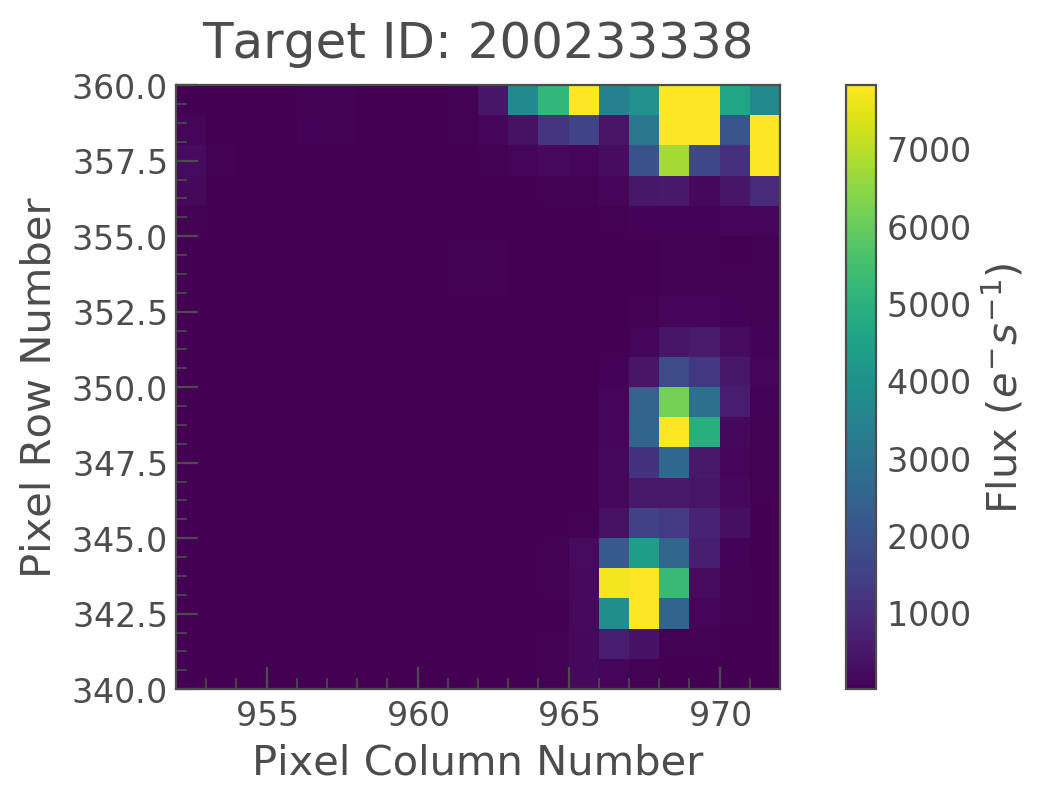

In [24]:
tpf.plot();

Oh no, which source is it??

In [25]:
delta_y, delta_x = tpf.wcs.all_world2pix(c.ra.value, c.dec.value, 1)
tpf.row + delta_x, tpf.column + delta_y

(343.8305006968113, 968.3140784132212)

It's in the low right corner.  Let's interact with the data...

In [26]:
#tpf.interact()

Woohoo!  we saved a lightcurve:

In [27]:
! ls *custom-lc.fits

ktwo200008674-c05_lpd-targ-custom-lc.fits
ktwo200233338-c18_lpd-targ-custom-lc.fits


Let's open up the saved file and apply SFF

In [28]:
from astropy.io import fits

In [29]:
custom_mask = fits.open('ktwo200233338-c18_lpd-targ-custom-lc.fits')['APERTURE'].data

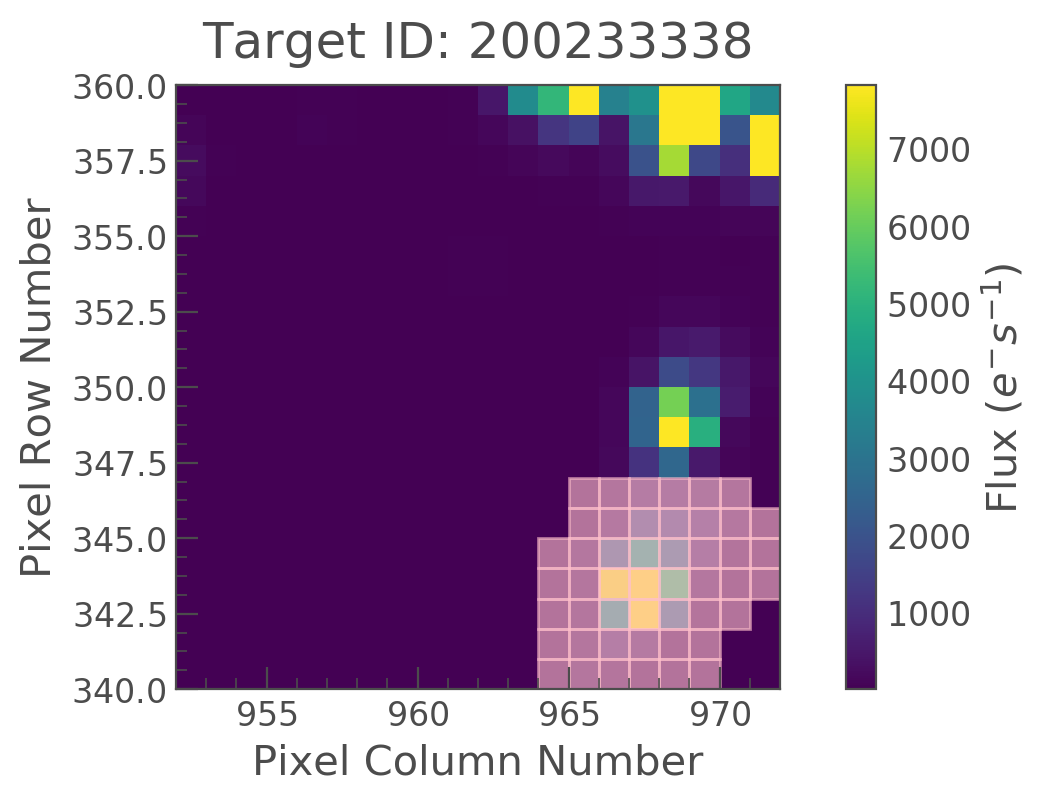

In [30]:
tpf.plot(aperture_mask=custom_mask)

In [31]:
lc_targ = tpf.extract_aperture_photometry(aperture_mask=custom_mask)

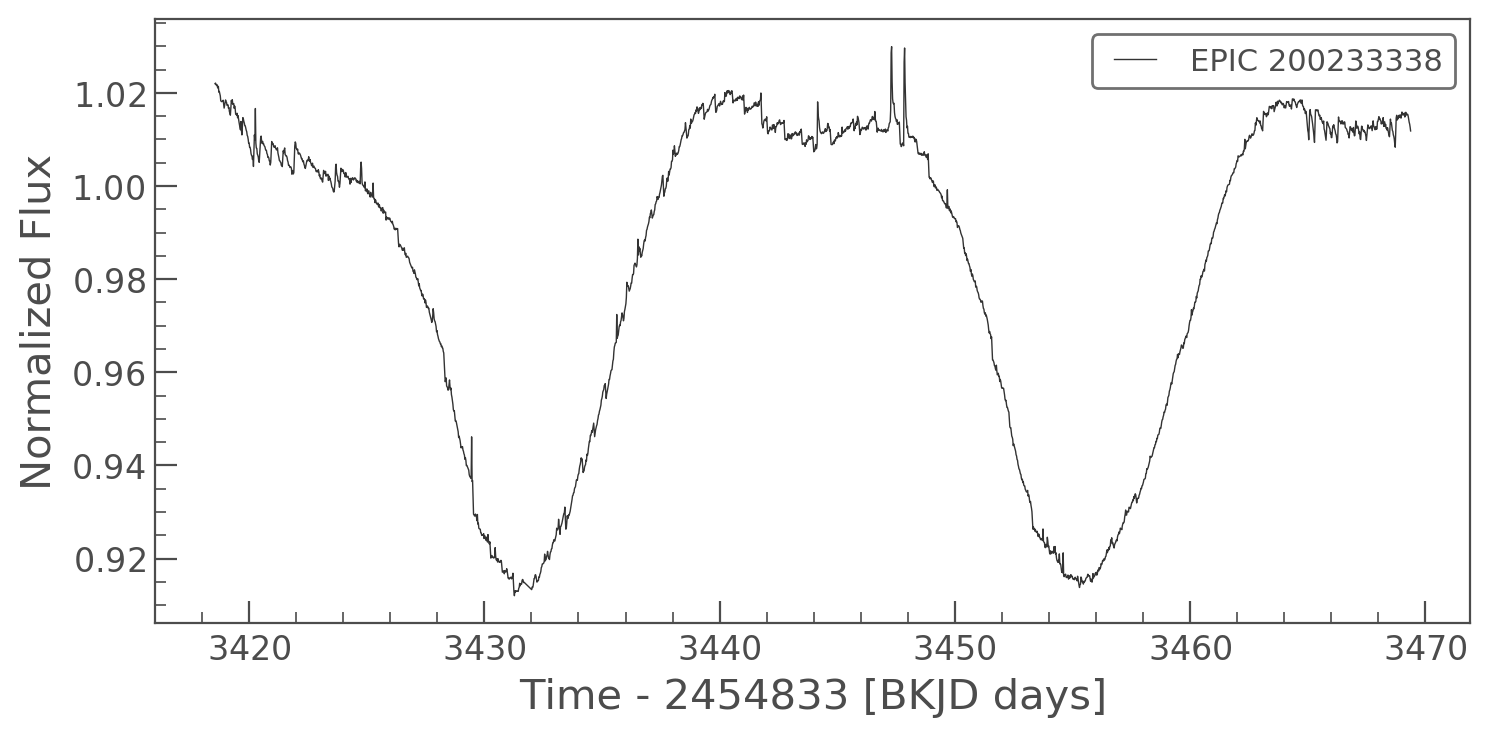

In [32]:
lc_targ.plot()

Yay!

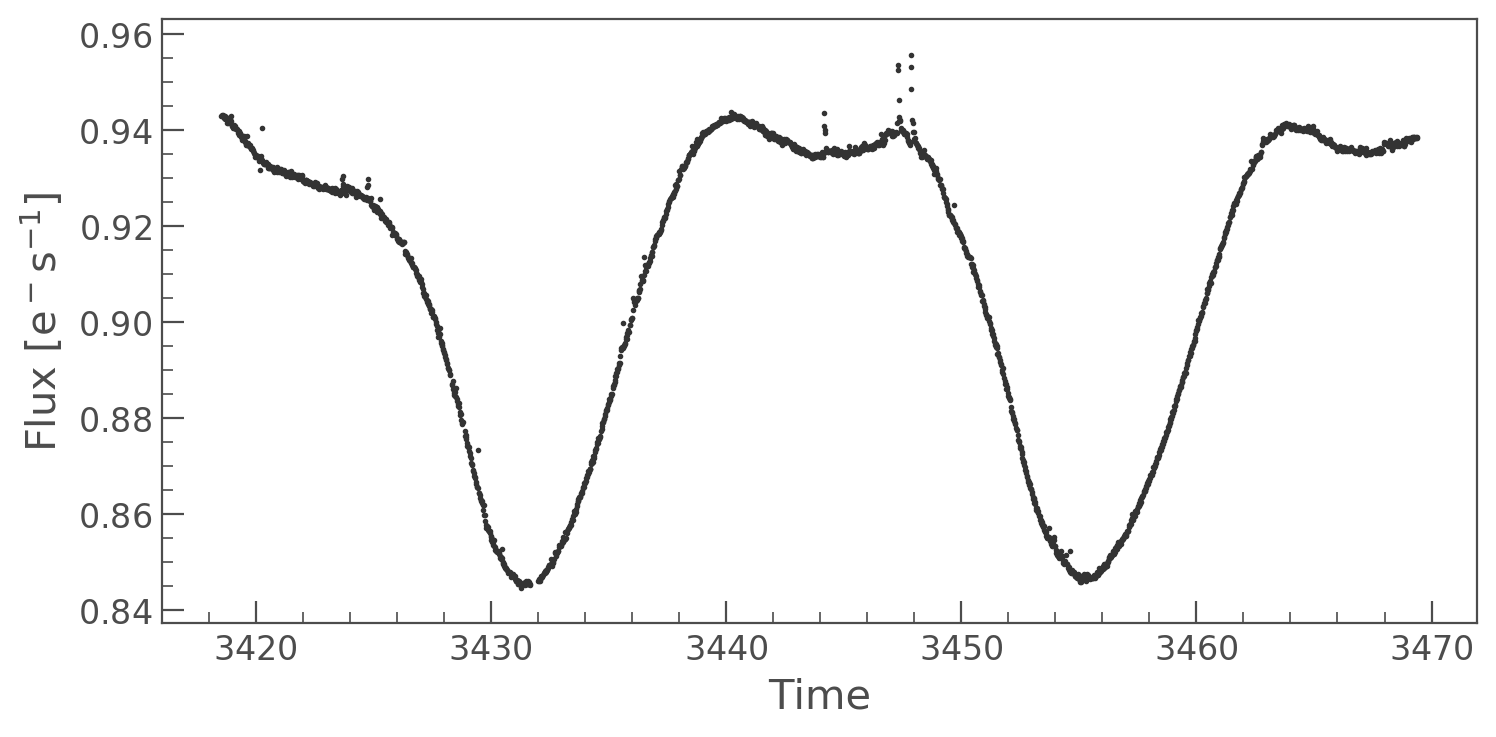

In [33]:
from lightkurve.correctors import SFFCorrector

sff = SFFCorrector()

lc_corrected = sff.correct(lc_targ.time, lc_targ.flux, 
                           lc_targ.centroid_col, lc_targ.centroid_row,
                           niters=5, windows=20, polyorder=5, restore_trend=True)

(lc_corrected.normalize()/1.08).scatter(normalize=False)

Nice!

In [34]:
df_out = lc_corrected.to_pandas()

In [35]:
df_out = df_out.reset_index(drop=True)[['time', 'flux']]
df_out.head()

,time,flux
0,3418.546541,73985.342160
1,3418.566974,73994.532839
2,3418.587406,73981.014196
3,3418.607838,73971.104432
4,3418.628271,73989.037345


In [41]:
df_out.to_csv('../data/K2/S1063_K2_C18_lightkurve_SFF.csv', index=False)

(2, 80)

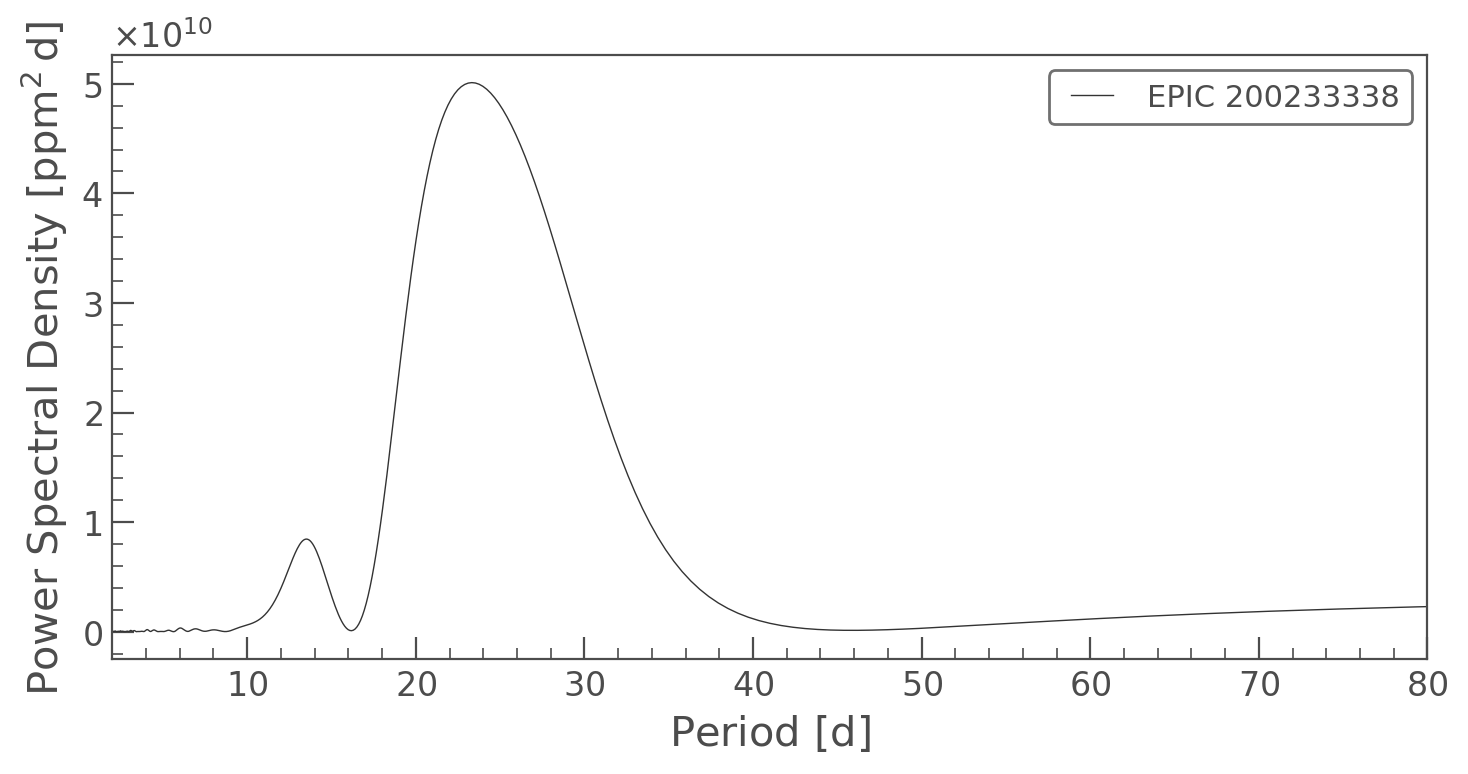

In [39]:
pg = lc_targ.to_periodogram(oversample_factor=50)
pg.plot(format='period')
plt.xlim(2, 80)

In [40]:
pg.period_at_max_power

<Quantity 23.31861158 d>